# Sentiment Analysis - Hotel Review  
* Bidirectional GRU
* Bidirectional LSTM
* SimpleRNN
* Neural Network

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve
import tensorflow as tf
from tensorflow import keras

from keras.layers import Embedding, Dense, LSTM, Bidirectional
from keras.layers import Flatten, GRU, Dropout, SimpleRNN,SpatialDropout1D, GlobalAveragePooling1D
from keras import Input, Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import plot_model

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Read Data
* Data Source: [Trip Advisor Hotel Review](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews) 

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv',engine='python')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.shape

(20491, 2)

In [5]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Label Review Rating


*   0 if rating is 1 or 2 or 3
*   1 if rating is 4 or 5

In [6]:
df['label'] = np.array(df['Rating'].apply(lambda x: 1 if x > 3 else 0))
df.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


## Preprocessing Review Text


*   remove integer values
*   breakdown to words by space delimiter 
*   remove stopwords using nltk library



In [7]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess(text):
    text = re.sub(r'\d+',' ',text)
    text = text.split()
    text = ' '.join([w for w in text if not w.lower().strip() in stop_words])
    return text

In [9]:
df['Review'] = df['Review'].apply(preprocess)


## Training and Testing Data Split

> Split data into train and test datasets with equal proportion of label.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)

## Tokenization

*   convert to lower case (default)
*   remove punctuation
*   integer encoding to word - map each word with unique index for each word with most common as 1 to least common xxx
*   sequence encoding to review
*   NOTE: require data to be str format

AVOID Data Leakage
*  build tokenizer using only training data





In [11]:
NWORDS = 10000
tknz = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz.fit_on_texts(X_train)

train_seq = tknz.texts_to_sequences(X_train)
test_seq = tknz.texts_to_sequences(X_test)

In [12]:
print(len(tknz.word_index))

44178


Padding
*   get the length of longest review text 
*   set all sequences to a uniform length with the longest review length by filling in with 0 
*   padding flag 'pre': pad 0 in the beginning
*   padding flag 'post': pad 0 in the end



In [13]:
MAX_SEQ_LEN =np.max(list(map(lambda x: len(x), train_seq)))+1
MAX_SEQ_LEN

1941

In [14]:
pad_train_seq = pad_sequences(train_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq = pad_sequences(test_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')


## Build Models & Performance Evaluation

*   Bidirectional GRU
*   Bidirectional LSTM
*   SimpleRNN
*   Neural Network


In [15]:
EMBED_DIM = 32
BATCH_SIZE = 1000
EPOCH = 30

In [16]:
def show_model_summary(model):
  print()
  print(model.summary())
  print()

In [17]:
def build_BiGRU(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(32,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', 
                           tf.keras.metrics.AUC(name='AUC'),
                           keras.metrics.AUC(name='PRC', curve='PR')])
  
  return model

In [18]:
def fit_model(model, model_name):
  history = model.fit(pad_train_seq,y_train,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,epochs=EPOCH,
                    verbose=0,
                    callbacks=[
                            EarlyStopping(
                            monitor='val_PRC',
                            patience=3,
                            mode = 'max',
                            restore_best_weights=True
                        )
                        
                    ]
                   )
  model.save(model_name)
  print(pd.DataFrame(model.history.history))
  return history

In [19]:
def plot_metrics(history):
  metrics = ['loss', 'PRC', 'AUC', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'AUC':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1941, 32)          320000    
                                                                 
 dropout (Dropout)           (None, 1941, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1941, 64)         12672     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1941, 64)          0         
                                                                 
 flatten (Flatten)           (None, 124224)            0         
                                                                 
 dense (Dense)               (None, 1)                 124225    
                                                       

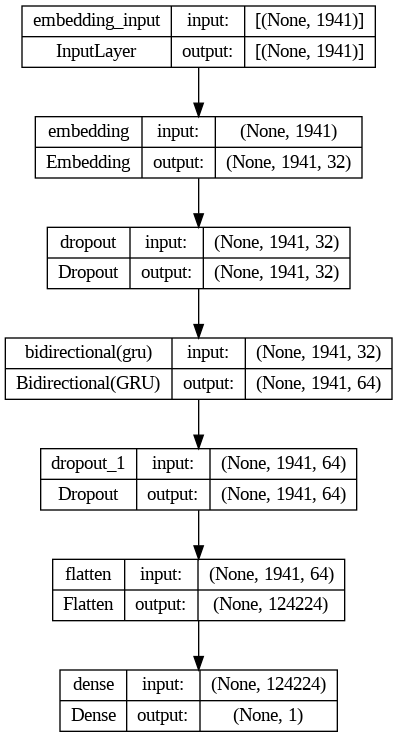

In [20]:
grumodel = build_BiGRU(EMBED_DIM)
show_model_summary(grumodel)
plot_model(grumodel,show_shapes=True)

### Model Training and Model Evaluation

       loss  accuracy       AUC       PRC  val_loss  val_accuracy   val_AUC  \
0  0.598420  0.709754  0.516063  0.741051  0.554000      0.750229  0.629240   
1  0.567360  0.732403  0.619726  0.815196  0.528634      0.750534  0.751523   
2  0.514978  0.743079  0.795242  0.909106  0.442318      0.777676  0.874363   
3  0.388928  0.827804  0.900254  0.956700  0.298796      0.885636  0.931943   
4  0.272811  0.891787  0.936803  0.972287  0.252780      0.896005  0.945337   
5  0.221932  0.911462  0.958447  0.982690  0.231027      0.902409  0.953928   
6  0.185198  0.929307  0.971295  0.987952  0.223822      0.906679  0.955887   
7  0.158567  0.938687  0.978570  0.991102  0.228719      0.909424  0.955841   
8  0.133511  0.949897  0.984166  0.993061  0.238944      0.906374  0.954694   

    val_PRC  
0  0.832680  
1  0.898352  
2  0.952800  
3  0.972675  
4  0.977814  
5  0.982377  
6  0.981566  
7  0.981148  
8  0.980202  


[0.2769879400730133,
 0.8889973163604736,
 0.9347023963928223,
 0.9715871214866638]

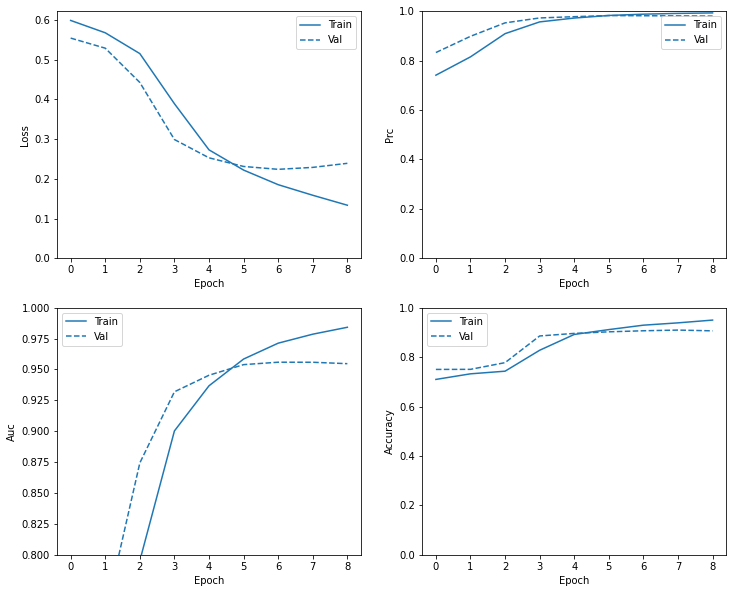

In [21]:
gruhistory = fit_model(grumodel,'./saved_model/grumodel1.h5')
plot_metrics(gruhistory)
gru_results = grumodel.evaluate(pad_test_seq,y_test,verbose=0)
gru_results

In [22]:
def build_LSTM(embedding_dim):
  model=Sequential()
  model.add(Embedding(NWORDS,embedding_dim,input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(32,return_sequences=True,recurrent_dropout=0.2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')])
  return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1941, 32)          320000    
                                                                 
 dropout_2 (Dropout)         (None, 1941, 32)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1941, 64)         16640     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1941, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 124224)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 124225    
                                                     

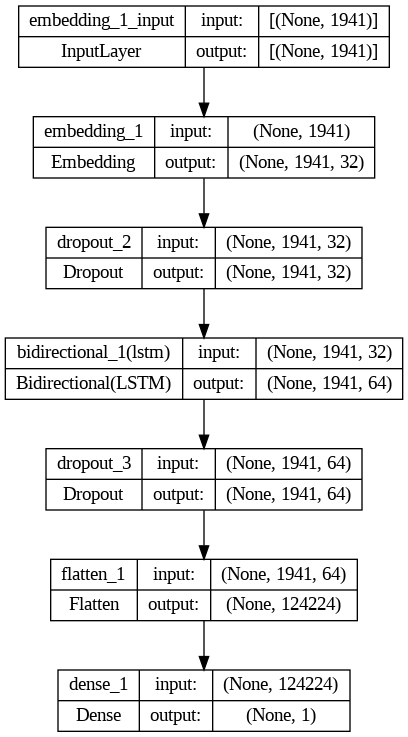

In [23]:
lstmmodel = build_LSTM(EMBED_DIM)
show_model_summary(lstmmodel)
plot_model(lstmmodel,show_shapes=True)

       loss  accuracy       AUC       PRC  val_loss  val_accuracy   val_AUC  \
0  0.598106  0.707008  0.521834  0.746319  0.553448      0.750534  0.636184   
1  0.560714  0.732403  0.658945  0.830222  0.513769      0.751449  0.775188   
2  0.480442  0.768550  0.823767  0.923650  0.351313      0.850869  0.911515   
3  0.300479  0.875162  0.923000  0.964682  0.262504      0.890820  0.946760   
4  0.238998  0.902768  0.953241  0.979833  0.225564      0.909119  0.955409   
5  0.190421  0.925951  0.968907  0.986723  0.222742      0.914608  0.957379   
6  0.158301  0.938534  0.978475  0.990840  0.219597      0.918573  0.958241   
7  0.136612  0.947609  0.983883  0.993104  0.254293      0.913083  0.953870   

    val_PRC  
0  0.833699  
1  0.905636  
2  0.966780  
3  0.978045  
4  0.982717  
5  0.982237  
6  0.982392  
7  0.978287  


[0.27199581265449524,
 0.8921688199043274,
 0.9371920824050903,
 0.9730061292648315]

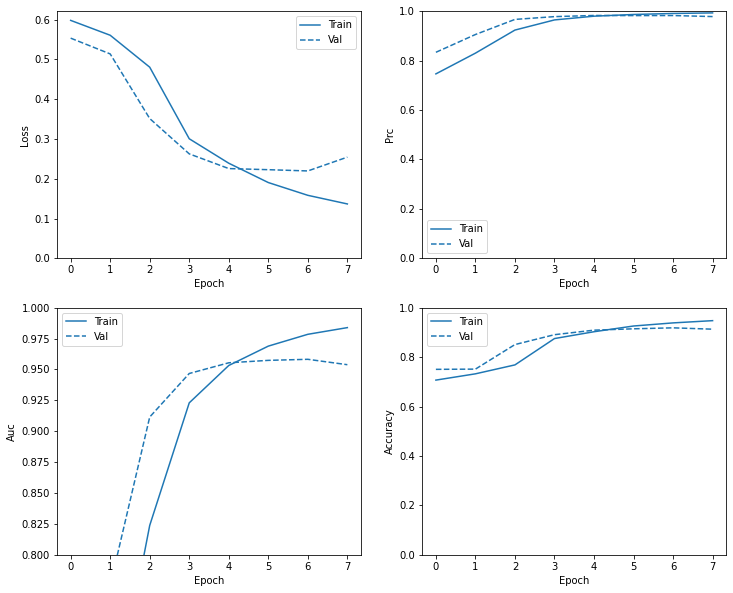

In [24]:
lstmhistory = fit_model(lstmmodel,'./saved_model/lsmtmodel1.h5')
plot_metrics(lstmhistory)
lstm_results = lstmmodel.evaluate(pad_test_seq,y_test,verbose=0)
lstm_results 

In [25]:
def build_RNN(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS,
                      output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(SimpleRNN(32, activation='relu',name="RNN_Layer"))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid', name="Output"))

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')])
  
  
  return model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1941, 32)          320000    
                                                                 
 dropout_4 (Dropout)         (None, 1941, 32)          0         
                                                                 
 RNN_Layer (SimpleRNN)       (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-t

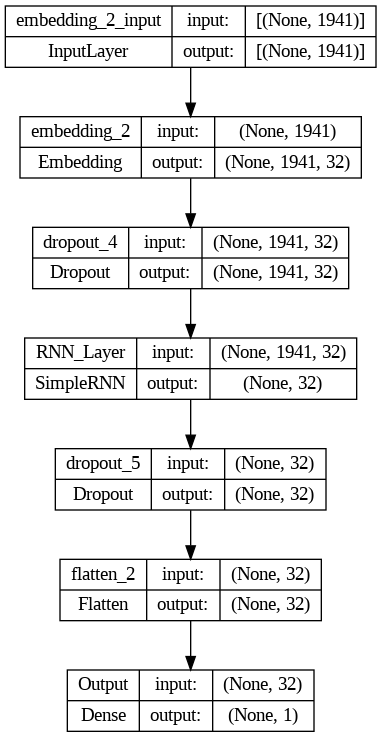

In [26]:
rnnmodel = build_RNN(EMBED_DIM)

show_model_summary(rnnmodel)
plot_model(rnnmodel,show_shapes=True)

       loss  accuracy       AUC       PRC  val_loss  val_accuracy  val_AUC  \
0  0.651765  0.671013  0.501030  0.734465  0.571314      0.751144      0.5   
1  0.592253  0.732708  0.507625  0.734766  0.567268      0.751144      0.5   
2  0.589160  0.732479  0.500083  0.732906  0.563067      0.751144      0.5   
3  0.586390  0.732937  0.508549  0.739119  0.563489      0.751144      0.5   

    val_PRC  
0  0.751144  
1  0.751144  
2  0.751144  
3  0.751144  


[0.5827502012252808, 0.7365211248397827, 0.5, 0.7365211844444275]

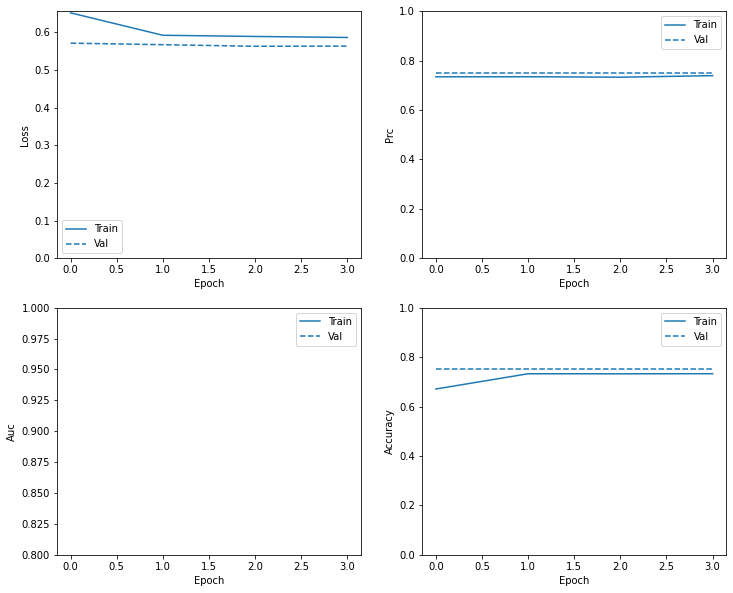

In [27]:
rnnhistory = fit_model(rnnmodel,'./saved_model/rnnmodel1.h5')
plot_metrics(rnnhistory)
rnn_results = rnnmodel.evaluate(pad_test_seq,y_test,verbose=0)
rnn_results 

In [28]:
def build_NN(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS,
                      output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN
                      ))
  model.add(Dropout(0.5))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(0.25))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')])


  return model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1941, 32)          320000    
                                                                 
 dropout_6 (Dropout)         (None, 1941, 32)          0         
                                                                 
 dense_2 (Dense)             (None, 1941, 32)          1056      
                                                                 
 dropout_7 (Dropout)         (None, 1941, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                     

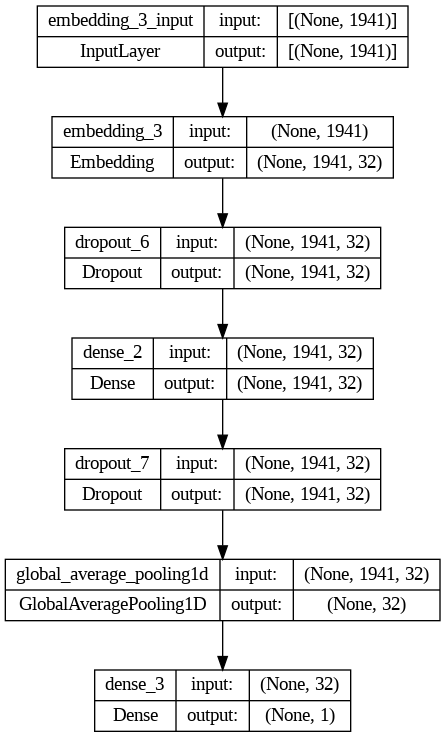

In [29]:
nnmodel = build_NN(EMBED_DIM)
show_model_summary(nnmodel)
plot_model(nnmodel,show_shapes=True)

        loss  accuracy       AUC       PRC  val_loss  val_accuracy   val_AUC  \
0   0.690388  0.552886  0.501314  0.734788  0.673541      0.751144  0.501034   
1   0.666503  0.732937  0.499110  0.732467  0.648974      0.751144  0.546121   
2   0.642220  0.732937  0.511230  0.738906  0.620831      0.751144  0.520254   
3   0.616287  0.732937  0.508067  0.741581  0.591458      0.751144  0.555736   
4   0.592982  0.732937  0.514200  0.745709  0.568952      0.751144  0.580373   
5   0.580825  0.732937  0.527684  0.752272  0.560351      0.751144  0.614522   
6   0.578849  0.732937  0.566457  0.775279  0.559079      0.751144  0.627962   
7   0.578843  0.732937  0.600622  0.792489  0.559098      0.751144  0.635419   
8   0.578295  0.732937  0.586214  0.784547  0.560015      0.751144  0.621089   
9   0.578159  0.732937  0.618638  0.804705  0.559539      0.751144  0.658252   
10  0.577863  0.732937  0.624572  0.806746  0.558851      0.751144  0.654298   
11  0.577541  0.732937  0.640439  0.8173

[0.5313156843185425,
 0.7443279027938843,
 0.7744323015213013,
 0.9035681486129761]

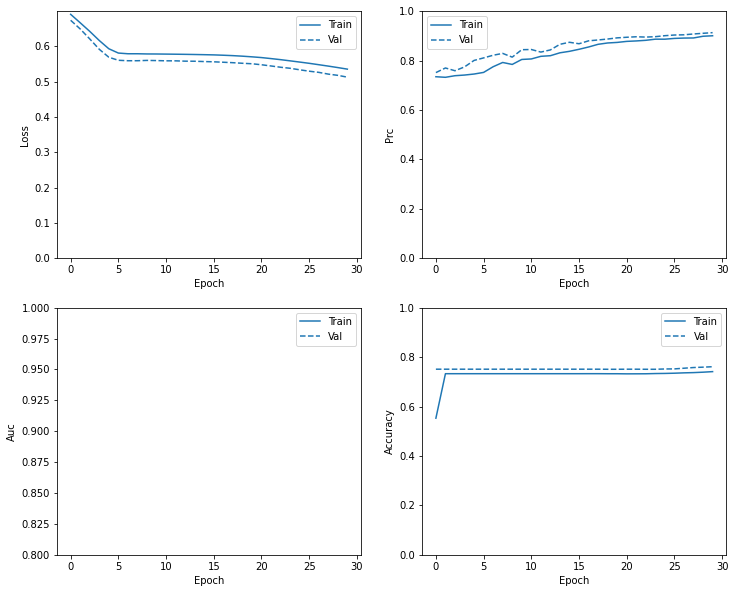

In [30]:
nnhistory = fit_model(nnmodel,'./saved_model/nnmodel1.h5')
plot_metrics(nnhistory)
nn_restuls = nnmodel.evaluate(pad_test_seq,y_test,verbose=0)
nn_restuls

### Test Data - Performance Evaluation Summary 
* Since this is an imbalance data problem - PRC and F1-score metrics are used to evaluate the performance of these 4 algorithms.  
* Bidirectional LSTM and Bidirectional GRU achieve best performance scores.    

In [31]:
print("Bidirectional GRU: ", gru_results)
print("Bidirectional LSTM: ", lstm_results)
print("SimpleRNN: ", rnn_results)
print("Neural Network: ", nn_restuls)

Bidirectional GRU:  [0.2769879400730133, 0.8889973163604736, 0.9347023963928223, 0.9715871214866638]
Bidirectional LSTM:  [0.27199581265449524, 0.8921688199043274, 0.9371920824050903, 0.9730061292648315]
SimpleRNN:  [0.5827502012252808, 0.7365211248397827, 0.5, 0.7365211844444275]
Neural Network:  [0.5313156843185425, 0.7443279027938843, 0.7744323015213013, 0.9035681486129761]


In [32]:
def test_eval(clf_model, testX, testy):
    # Test set prediction
    y_pred=clf_model.predict(testX)
    y_predict = []
    for p in y_pred:
        if p > 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    print('Confusion Matrix')
    print('='*60)
    cm = confusion_matrix(testy,y_predict)
    print(cm,"\n")
    print('Classification Report')
    print('='*60)
    cr = classification_report(testy,y_predict)
    print(cr,"\n")
    
    return cm,cr,y_predict

def plot_cmatrix(cmatrix, name):
    fig = px.imshow(cmatrix,color_continuous_scale=[[0.0, 'peachpuff'], 
                                          [0.5, 'lime'], 
                                          [1.0, 'green']])

    fig.update_layout(
        title = 'Confusion Matrix ('+ name + ')', title_x=0.5,
        xaxis_title="Predicted Label", yaxis_title="Actual Label", 
        height=400,
        width=400,
        xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1),
        yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1)
    )
    for i in range(len(cmatrix)):
        for j in range(len(cmatrix[0])):
            fig.add_annotation(
                x=j,
                y=i,
                text=str(cmatrix[i,j]),
                showarrow=False,
                font_size=9, font_color='black'
            )

    fig.show()


cm1,cr1,_  = test_eval(grumodel,pad_test_seq,y_test)
cm2,cr2,_  = test_eval(lstmmodel,pad_test_seq,y_test)
cm3,cr3,_  = test_eval(rnnmodel,pad_test_seq,y_test)
cm4,cr4,_  = test_eval(nnmodel,pad_test_seq,y_test)

plot_cmatrix(cm1, name='Bidirectional GRU')
plot_cmatrix(cm2, name='Bidirectional LSTM')
plot_cmatrix(cm3, name='SimpleRNN')
plot_cmatrix(cm4, name='Neural Network')

129/129 [==============================] - 7s 51ms/step
Confusion Matrix
[[ 827  253]
 [ 202 2817]] 

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1080
           1       0.92      0.93      0.93      3019

    accuracy                           0.89      4099
   macro avg       0.86      0.85      0.85      4099
weighted avg       0.89      0.89      0.89      4099
 

129/129 [==============================] - 134s 1s/step
Confusion Matrix
[[ 793  287]
 [ 155 2864]] 

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1080
           1       0.91      0.95      0.93      3019

    accuracy                           0.89      4099
   macro avg       0.87      0.84      0.86      4099
weighted avg       0.89      0.89      0.89      4099
 

129/129 [==============================] - 20s 156ms/step
Confusion Matrix
[[   0 1080]
 [   0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Confusion Matrix
[[  83  997]
 [  51 2968]] 

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.08      0.14      1080
           1       0.75      0.98      0.85      3019

    accuracy                           0.74      4099
   macro avg       0.68      0.53      0.49      4099
weighted avg       0.71      0.74      0.66      4099
 



In [33]:
precision1, recall1, _ = precision_recall_curve(y_test, grumodel.predict(pad_test_seq))
precision2, recall2, _ = precision_recall_curve(y_test, lstmmodel.predict(pad_test_seq))
precision3, recall3, _ = precision_recall_curve(y_test, rnnmodel.predict(pad_test_seq))
precision4, recall4, _ = precision_recall_curve(y_test, nnmodel.predict(pad_test_seq))

129/129 [==============================] - 0s 2ms/step


In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=recall1,y=precision1,mode='lines',name='Bidirectional GRU'))
fig.add_trace(go.Scatter(x=recall2,y=precision2,mode='lines',name='Bidirectional LSTM'))
fig.add_trace(go.Scatter(x=recall3,y=precision3,mode='lines',name='SimpleRNN'))
fig.add_trace(go.Scatter(x=recall4,y=precision4,mode='lines',name='Neural Network'))
fig.update_layout(title='Precision-Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision', title_x = 0.5,
                   width = 800, height=450,
                 )
fig.show()